# Lab 2d: Fun With Principle Component Analysis (PCA)
Fill me in

## Task 1: Setup, Data and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl")

### Data
We developed a simple software development kit (SDK) against [the BiGG Models application programming interface at the University of California, San Diego](http://bigg.ucsd.edu/). The [BiGG Models database](http://bigg.ucsd.edu/) integrates published genome-scale metabolic networks into a single database with standardized nomenclature and structure. 
* [The BiGG models API](http://bigg.ucsd.edu/data_access) allows users to programmatically access genome-scale stoichiometric model reconstructions using a simple web API. There are `108` models of intracellular biochemistry occurring in various organisms (including humans) in the database (so far); [see here for a list of models](http://bigg.ucsd.edu/models).
* Here, we'll first explore the [core metabolic model of Palsson and coworkers](https://pubmed.ncbi.nlm.nih.gov/26443778/), which is a scaled-down model of [carbohydrate metabolism](https://en.wikipedia.org/wiki/Carbohydrate_metabolism) in _E.coli_. This model has 72 metabolites and 95 reactions. We'll then look at other models, and see what is going on with these.

We call the model download endpoint of [the BiGG models API](http://bigg.ucsd.edu/data_access) and then save the model file to disk (so we don't hit the API unless we have to). This call returns model information organized as [a Julia dictionary](https://docs.julialang.org/en/v1/base/collections/#Base.Dict) in the `model::Dict{String, Any}` variable. If a model file is saved, we use the cached file instead of making an API call.

In [5]:
model = let

    # build download endpoint -
    baseurl = "http://bigg.ucsd.edu"; # base url to download model
    modelid = "iAB_RBC_283"; # model id to download
    path_to_saved_model_file = joinpath(_PATH_TO_DATA, "saved-model-$(modelid).jld2");

    # check: do we have a model file saved?
    model = nothing;
    if (isfile(path_to_saved_model_file) == false)
        
        endpoint = MyBiggModelsDownloadModelEndpointModel();
        endpoint.bigg_id = modelid;
        url = build(baseurl, endpoint)
        model = MyBiggModelsDownloadModelEndpointModel(url);

        # Before we move on, save this model for later (so we don't keep hitting the API)
        save(path_to_saved_model_file, Dict("model" => model));
    else
        model = load(path_to_saved_model_file)["model"];
    end
    model; # return the model (either saved, or downloaded)
end

Dict{String, Any} with 6 entries:
  "metabolites"  => Any[Dict{String, Any}("compartment"=>"c", "name"=>"3-Phosph…
  "id"           => "iAB_RBC_283"
  "compartments" => Dict{String, Any}("c"=>"cytosol", "e"=>"extracellular space…
  "reactions"    => Any[Dict{String, Any}("name"=>"Sink pchol hs 18 1 18 1(c)",…
  "version"      => "1"
  "genes"        => Any[Dict{String, Any}("name"=>"NMRK1", "id"=>"Nrk1_AT1", "n…

__Stoichiometric matrix__: Next, let's build a stoichiometric matrix $\mathbf{S}$ using the metabolite and reaction records. We'll do this using two for loops. 
* __Strategy__: In the outer loop, we iterate over the system's metabolites (chemical species) and select the `id` from the metabolites record for each metabolite. In the inner loop, we iterate over each reaction. For each reaction record, we ask if this reaction has an entry for the current metabolite `id` value; if it does, we grab the stoichiometric coefficient $\sigma_{ij}$ corresponding to this metabolite and reaction.

In [7]:
S = let

    # get some data from the model -
    m = model["metabolites"]; # get list of metabolites
    r = model["reactions"]; # get list of reactions
    number_of_rows = length(m); # how many metabolites do we have? (rows)
    number_of_cols = length(r); # how many reactions do we have? (cols)
    S = zeros(number_of_rows,number_of_cols); # initialize an empty stoichiometric matrix

    # let's build a stm -
    for i ∈ eachindex(m)
        metabolite = m[i]["id"]; # we are checking if this metabolite is in the reaction record
        for j ∈ eachindex(r)
            reaction = r[j];
            if (haskey(reaction["metabolites"], metabolite) == true)
                S[i,j] = reaction["metabolites"][metabolite];
            end
        end
    end
    S; 
end;

Z-score center the stoichiometrix matrix $\mathbf{S}$

In [9]:
Ŝ = let
    
    # get some data from the system -
    m = model["metabolites"] |> length # get the number of metabolites
    r = model["reactions"] |> length # get the number of reactions
    Ŝ = zeros(m,r); # create a scaled stoichiometric matrix

    for j ∈ 1:r
        col = S[:,j]; # get the jth col (reaction)
        μⱼ = mean(col); # mean of the col
        σⱼ = std(col); # std of the col

        for i ∈ 1:m
            Ŝ[i,j] = (col[i] - μⱼ)/σⱼ;
        end
    end

    Ŝ
end

342×469 Matrix{Float64}:
 0.0540738  0.0540738  0.0540738  …  -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738  …  -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738  …  -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 0.0540738  0.0540738  0.0540738     -0.0241542  -0.0241542  -0.0241542
 ⋮                                ⋱    

In [10]:
Σ̂ = cov(Ŝ) # covariance

469×469 Matrix{Float64}:
  1.0          -0.00293255  -0.00293255   …   0.00130994    0.00130994
 -0.00293255    1.0         -0.00293255       0.00130994    0.00130994
 -0.00293255   -0.00293255   1.0              0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255       0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255       0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255   …   0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255      -0.44669       0.00130994
 -0.00293255   -0.00293255  -0.00293255       0.00130994   -0.44669
 -0.00293255   -0.00293255  -0.00293255       0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255       0.00130994    0.00130994
 -0.00293255   -0.00293255  -0.00293255   …   0.00130994    0.00130994
  0.0           0.0          0.0              0.0           0.0
  0.0009502     0.0009502    0.0009502        0.144736      0.144736
  ⋮                                       ⋱                
 -1.

### Constants

In [12]:
ϵ = -5; # exponent below which we consider 0

## Task 2: Let's test some of the theoretical claims from the SVD lecture
In this task, let's test a few of the claims about singular value decomposition. The singular Value Decomposition (SVD) decomposes a matrix $\mathbf{A}\in\mathbb{C}^{n\times{m}}$ into three distinct matrices, $\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$. The matrices $\mathbf{U}$ and $\mathbf{V}$  are orthogonal matrices containing the left and right singular vectors, respectively, while the $\mathbf{\Sigma}$ is a diagonal matrix containing the singular values.
 In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the left and right singular vectors align with the eigenvectors.
* __Singular values__ of a matrix $\mathbf{A}$ are the square roots of the non-zero eigenvalues of either $\mathbf{A}\mathbf{A}^{\top}$ or $\mathbf{A}^{\top}\mathbf{A}$, establishing a direct connection between these two values. In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the singular values correspond directly to the absolute values of the eigenvalues.

### Claim 1: Singular vectors are eigenvectors of matrix products
The singular vectors contained in the columns of the $\mathbf{U}$ and $\mathbf{V}$ are the eigenvectors of the matrix product $\mathbf{S}\mathbf{S}^{\top}$ and $\mathbf{S}^{\top}\mathbf{S}$, respectively for the _non-zero_ eigenvalues. We start by testing the left singular matrix $\mathbf{U}$ by computing the SVD of the matrix product $\mathbf{S}\mathbf{S}^{\top}$ and compare it to the eigendecomposition. Then, we'll do the same for the product $\mathbf{S}^{\top}\mathbf{S}$ compared to right-singular matrix $\mathbf{V}$.

In [15]:
U₁,Σ₁,VT₁ = let

    # compute SVD -
    A = S*transpose(S); # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A? (this should be square)
    F = svd(A, full = true, alg=LinearAlgebra.QRIteration()); # notice we are using QR iteration!
    U = F.U;
    Σ = F.S;
    V = F.V;

    U, Σ, V
end;

Compute the eigendecomposition for the matrix $\mathbf{S}\mathbf{S}^{\top}$.

In [17]:
Λ₁,V₁ = let

    # initialize -
    A = S*transpose(S); # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A?
    Λ = Matrix{Float64}(1.0*I, n, n); # builds the I matrix, we'll update with λ -
    
    # Decompose using the built-in function
    F = eigen(A);   # eigenvalues and vectors in F of type Eigen (biggest first)
    λ = F.values;   # vector of eigenvalues
    V = F.vectors;  # n x n matrix of eigenvectors, each col is an eigenvector

    # package the eigenvalues into Λ -
    reverse!(λ)
    for i ∈ 1:n
        Λ[i,i] = λ[i];
    end

    Λ,V
end;

Compute the test

In [19]:
let 
    index = 339; # index of the vector we want to look at 
    uᵢ = U₁[:,index];
    vᵢ = V₁[:,end - (index-1)]; # DQ: why are we going from the end?
    dot(uᵢ,vᵢ)
end

0.9999999999999999

### Claim 2: Singular vectors of a symmetric real positive definite matrix are the eigenvectors
In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the left and right singular vectors align with the eigenvectors. Let's test this claim by first computing the singular value decomposition of the covariance matrix $\mathbf{\Sigma}$, then we'll compute the eigenvalues and eigenvectors of $\mathbf{\Sigma}$, and finally, we'll compare the singular vectors with the eigenvectors.

In [21]:
U₂,Σ₂,VT₂ = let

    # compute SVD -
    A = Σ̂; # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A? (this should be square)
    F = svd(A, full = true, alg=LinearAlgebra.QRIteration()); # notice we are using QR iteration!
    U = F.U;
    Σ = F.S;
    V = F.V;

    U, Σ, V
end;

Next, compute the eigendecomposition of the covariance matrix $\mathbf{\Sigma}$ using [the `eigen(...)` method exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen)

In [23]:
Λ₂,V₂ = let

    # initialize -
    A = Σ̂; # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A?
    Λ = Matrix{Float64}(1.0*I, n, n); # builds the I matrix, we'll update with λ -
    
    # Decompose using the built-in function
    F = eigen(A) ;   # eigenvalues and vectors in F of type Eigen (biggest first)
    λ = F.values;   # vector of eigenvalues
    V = F.vectors;  # n x n matrix of eigenvectors, each col is an eigenvector

    # package the eigenvalues into Λ -
    reverse!(λ)
    for i ∈ 1:n
        Λ[i,i] = λ[i];
    end

    Λ,V
end;

Compute

In [25]:
δ₂ = let 
    index = 4; # index of the vector we want to look at 
    uᵢ = U₂[:,index];
    vᵢ = V₂[:,end - (index-1)]; # DQ: why are we going from the end?
    dot(uᵢ,vᵢ)
end

1.0000000000000009

In [26]:
index = 1
uᵢ = U₂[:,index];
vᵢ = V₂[:,end - (index-1)]; # DQ: why are we going from the end?
[uᵢ vᵢ]

469×2 Matrix{Float64}:
 -0.000418497   0.000418497
 -0.000416429   0.000416429
 -0.000416429   0.000416429
 -0.000418504   0.000418504
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000153178  -0.000153178
  0.000569968  -0.000569968
 -0.085201      0.085201
  ⋮            
 -0.000175824   0.000175824
 -0.000252893   0.000252893
 -0.0825653     0.0825653
 -0.0492508     0.0492508
  0.0493045    -0.0493045
 -0.0727806     0.0727806
 -0.050529      0.050529
 -0.050529      0.050529
 -0.0505281     0.0505281
 -0.0507899     0.0507899
 -0.0507899     0.0507899
 -0.0507899     0.0507899

## Task 3: Dimensionality reduction with Principle Component Analysis (PCA)
Fill me in

In [28]:
y = let

    # initialize -
    k = 2; # reduced dimension
    number_of_cols = size(U₂,2);
    P = zeros(k,number_of_cols); # transformation matrix

    # build P -
    for i ∈ 1:k
        for j ∈ 1:number_of_cols
            P[i,j] = U₂[i,j];
        end
    end
    y = P*transpose(S) |> transpose |> Matrix
end

342×2 Matrix{Float64}:
  0.00210298  -0.0379181
 -0.00184324   0.000162669
 -0.0164081   -0.00335246
 -0.0289936   -0.00655094
 -0.0650449    0.0836294
  0.010075    -0.103997
 -0.0424376    0.0348275
 -0.0185527   -0.0147826
  0.0453939    0.00936713
 -0.0247263   -0.0252669
 -0.0243435   -0.0463846
  0.0284606    0.0511428
 -0.0242132    0.0308337
  ⋮           
 -0.00791339   0.0246603
  0.0474125   -0.0496737
 -0.00256425  -0.00235645
 -0.0440108    0.0104852
  0.0057512   -0.00244963
  0.0935385   -0.0107891
  0.0543749    0.020088
 -0.041875    -0.00516087
 -0.0143163   -0.0280435
 -0.0105698   -0.0132115
 -0.0050986    5.07953e-5
  0.0375424    0.0268691

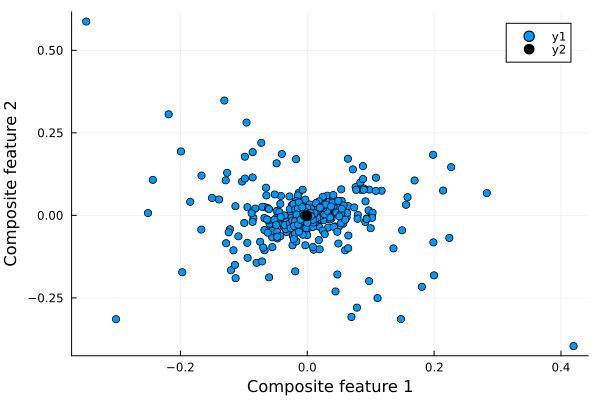

In [29]:
let
    
    # compute the centroid -
    c = mean(y,dims=1);
    scatter(y[:,1], y[:,2])
    scatter!([c[1]],[c[2]],ms=6,mc=:black)
    xlabel!("Composite feature 1", fontsize=18)
    ylabel!("Composite feature 2", fontsize=18)
end

In [30]:
î = let

        

end